In [ ]:
### To-Do
# X) make fit_function general enough for pswarms optimization -> dropout rate, layers, nodes, etc
# X) write function that runs fit_function ~5 times and keeps ensemble + best
# 3) put all this in a script
# 4) save output distribution and history plots in model directory
# 5) log file of some kind?
# X) e_sig vs (1-e_bkg) plot
# 7) implement pyswarms optimization
# -) ... 
# N) k-fold validation

In [1]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2
from keras.models import load_model
from keras.backend import manual_variable_initialization 
import json

manual_variable_initialization(True)

from lbn import LBN, LBNLayer

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


In [2]:
import sys, os
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

topDir = '/home/btannenw/Desktop/ML/dihiggsMLProject/lorentzBoostNetwork/'

In [3]:
#*** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

Dihiggs file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/pp2hh4b_500kEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv
QCD file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/ppTo4b_2MEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv


(array([3.3195e+04, 4.0870e+04, 2.5949e+04, 1.1225e+04, 3.8130e+03,
        1.1030e+03, 2.6100e+02, 5.6000e+01, 5.0000e+00, 4.0000e+00]),
 array([ 4. ,  4.9,  5.8,  6.7,  7.6,  8.5,  9.4, 10.3, 11.2, 12.1, 13. ]),
 <a list of 10 Patch objects>)

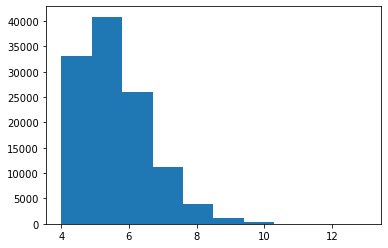

In [4]:
plt.hist(qcd_raw.nJets, bins=10)

In [5]:
# *** 2. Make mix of dihiggs and QCD for specified variables
jetLabels = ['1','2','3','4','5','6','7','8']
jetVariables = ['energy', 'px', 'py', 'pz']
variables_jetVects = ['jet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]

# *** 2. Split testing and training
jetVects_data_train, jetVects_data_test, jetVects_labels_train, jetVects_labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables_jetVects, testingFraction)

N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [6]:
# *** 2. Create jet vector inputs
def returnJetVectorInputsToLBN(_df, _jetType='jet', _nJets=4):
    
    #flattened
    _allVectorsFlattened = None
    _var = [_jetType+'{}_energy', _jetType+'{}_px', _jetType+'{}_py', _jetType+'{}_pz']
    
    for i in range(1, _nJets + 1):
        _varN = [x.format(i) for x in _var]
        _jetNData = _df[ _varN ].astype(np.float32)
        _vectN = [list(x) for x in _jetNData.values]
        
        if _allVectorsFlattened == None:
            _allVectorsFlattened = _vectN
        else:
            _allVectorsFlattened = [ x + y for x,y in zip(_allVectorsFlattened, _vectN) ]

    return np.array(_allVectorsFlattened)
    

nJets = 8
jetType = 'jet'
trainVectorsByEvent = returnJetVectorInputsToLBN( jetVects_data_train, jetType, nJets)
testVectorsByEvent  = returnJetVectorInputsToLBN( jetVects_data_test, jetType, nJets)

trainLabelsByEvent = np.array([[0.,1.] if x ==0 else [1.,0.] for x in jetVects_labels_train.isSignal]).astype(np.float32)
testLabelsByEvent  = np.array([[0.,1.] if x ==0 else [1.,0.] for x in jetVects_labels_test.isSignal]).astype(np.float32)

print(np.shape(trainVectorsByEvent))

# *** Make signal/background specific containers for labelled evaluation 
hh_data_test, hh_labels_test, qcd_data_test, qcd_labels_test = returnTestSamplesSplitIntoSignalAndBackground(testVectorsByEvent, testLabelsByEvent)

(136749, 32)
(58608, 2)


In [7]:
# *** 3A. Define LBN model and train
def createModelLBN( user_hyperparameters={}, _weightsDir=''):
    """make lbn model"""
    
    _hyperparameters = {'nLBNParticles':            5,
                       'nodesInFirstHiddenLayer':  80, 
                       'nodesInSecondHiddenLayer': 256, 
                       'hiddenActivation':        'relu', 
                       'outputActivation':        'sigmoid', 
                       'lossFunction':            'binary_crossentropy'
                       }

    print("++ Setting hyperparameters...")
    for hp in _hyperparameters.keys():
        if hp in user_hyperparameters.keys():
            _hyperparameters[hp] = user_hyperparameters[hp] 
        
        print("{} = {}".format(hp, _hyperparameters[hp]))
    
    
    #init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=123)
 
    features = ["E", "pt", "eta", "phi", "m", "pair_dr"]
    lbn_layer = LBNLayer(n_particles= _hyperparameters['nLBNParticles'], boost_mode="pairs", features=features)
    
    
    metrics = [
        tf.keras.metrics.categorical_accuracy,
        tf.keras.metrics.AUC(name='auc'),
    ]
        
    l2_reg = tf.keras.regularizers.l2(1e-4)
    
    dense_kwargs_IML = dict(
        activation="selu",
        kernel_initializer=tf.keras.initializers.lecun_normal(),
        kernel_regularizer=l2_reg,
    )

    dense_kwargs = dict(
        activation = _hyperparameters['hiddenActivation'],
        kernel_initializer=tf.keras.initializers.lecun_normal(),
        kernel_regularizer=l2_reg,
    )

    _model = tf.keras.models.Sequential()

    #_model.add(LBNLayer(5, boost_mode=LBN.PAIRS, features=features))
    _model.add(lbn_layer)
    _model.add(tf.keras.layers.BatchNormalization(axis=1))


    _model.add(tf.keras.layers.Dense(_hyperparameters['nodesInFirstHiddenLayer'], **dense_kwargs))
    _model.add(tf.keras.layers.Dense(_hyperparameters['nodesInSecondHiddenLayer'], **dense_kwargs))


    #_model.add(tf.keras.layers.Dense(750, activation='relu'))#, kernel_regularizer=l2_reg))
    #_model.add(tf.keras.layers.Dense(256, activation='relu'))
    #_model.add(tf.keras.layers.Dropout(0.2))
    
    #_model.add(tf.keras.layers.Dense(128, activation='relu'))
    #_model.add(tf.keras.layers.Dense(64, activation='relu'))
    #_model.add(tf.keras.layers.Dense(32, activation='relu'))

    _model.add(tf.keras.layers.Dense(2, activation=_hyperparameters['outputActivation'], kernel_regularizer=l2_reg))
        
    _model.compile(loss= _hyperparameters['lossFunction'],
                    optimizer='adam',
                    metrics = metrics
                 )
    
    if _weightsDir !='':
        
        local_dir = os.path.join(topDir, "lbn", "models", _weightsDir)
        modelfile = os.path.join(local_dir, _weightsDir)+'.hdf5'
        print("++ loading model from {}".format(modelfile))
        #<-- FIXME: this does not check if file exits
    
        _model.predict(np.empty([1,32]))
        _model.load_weights(modelfile)

        
    return _model, _hyperparameters

In [8]:
def fit_model(name, data=None, validation_data=None, epochs=10, batch_size=512, model_hyperparams={}):
   
    # *** 0. Create model
    _model, _hyperparameters = createModelLBN(model_hyperparams)

    # *** 1. Define output directory
    model_dir = os.path.join(topDir, "lbn", "models", name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # *** 2. Define callbacks for training
    fit_callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(model_dir, name)+'.hdf5',
            save_best_only=True,
            save_weights_only=True,
            monitor="val_auc",
            mode="max",
            #monitor="val_loss",
            #mode="min",
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_auc",
            mode="max",
            #monitor='val_loss', 
            #mode='min', 
            verbose=1, 
            patience=100,  
            min_delta=.0025,
        ),
    ]

    # *** 3. Safety checks for data
    if data is None:
        data = (trainVectorsByEvent, trainLabelsByEvent)
    if validation_data is None:
        validation_data = (testVectorsByEvent, testLabelsByEvent)

        
    # *** 4. Fit!!
    print('++ Begin model training\n')
    _history = _model.fit(data[0], data[1],
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=fit_callbacks,
    )

    
    # *** 5. Save hyperparameters
    hp_filename=os.path.join(model_dir, name)+'_hyperparameters.json'
    with open(hp_filename, 'w') as outfile:
        json.dump( _hyperparameters, outfile)
    
    
    return _model, _history


def load_model(_modelDirectory):
    """load previously created model"""
    
    # *** 0. Get hyperparameters
    local_dir = os.path.join(topDir, "lbn", "models", _modelDirectory)
    hp_file = os.path.join(local_dir, _modelDirectory)+'_hyperparameters.json'
    print("++ loading hyperparameters from {}".format(hp_file))
    
    with open(hp_file, 'r') as infile:
        _hyperparameters = json.load(infile)
        
    # *** 1. Create model
    _model, _hyperparameters = createModelLBN(_hyperparameters, _modelDirectory)

    return _model

In [ ]:
# *** 3A. Do things the proper, functional way

modelName = 'model_10TrainEpochs'

model, history = fit_model(name=modelName, data=(trainVectorsByEvent, trainLabelsByEvent), 
                          validation_data=(testVectorsByEvent, testLabelsByEvent), epochs=10, batch_size=400)

best_model = load_model( modelName )


In [ ]:
# *** 3B. Do things "by hand"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=.001)
mc = ModelCheckpoint('best_model.hdf5', #filepath=os.path.join(model_dir, name),
                    monitor="val_loss", mode='min', save_weights_only=True, save_best_only=True)
 

#model = createModelLBN(_outputActivation='softmax') # 1.77+/0.04, 1.84 +/- 0.06
model2 = createModelLBN(_outputActivation='sigmoid') # 1.81+/0.06

history = model2.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=50, validation_data = (testVectorsByEvent, testLabelsByEvent), batch_size=400, callbacks=[es, mc])
#history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=10, validation_data = (testVectorsByEvent, testLabelsByEvent))
print(model2.count_params())

# load the saved model
#model_best = model.load_weights('best_model.h5')

In [ ]:
# *** 3C. Define low-level NN using jet vectors for comparison
model_nn = tf.keras.models.Sequential()
nInputNodes = len(trainVectorsByEvent[0]) 
#model.add(Dense(100, input_dim=nInputNodes, activation='relu'))

model_nn.add(tf.keras.layers.Dense(128, input_dim = nInputNodes, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(BatchNormalization())

model_nn.add(tf.keras.layers.Dense(64, activation='relu'))
model_nn.add(tf.keras.layers.Dense(32, activation='relu'))
model_nn.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model_nn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_nn = model_nn.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=50, validation_data = (testVectorsByEvent, testLabelsByEvent), batch_size=400)
#history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=10, validation_data = (testVectorsByEvent, testLabelsByEvent))
print(model_nn.count_params())

In [ ]:
# *** 4. Make predictions using the "best" model from training
best_model = load_model('model_10TrainEpochs')

pred_hh = best_model.predict(np.array(hh_data_test))
pred_qcd = best_model.predict(np.array(qcd_data_test))

In [ ]:
# *** 5. Make plot of prediction results
_nBins = 40
predictionResults = {'hh_pred':pred_hh[:,0], 'qcd_pred':pred_qcd[:,0]}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'LBN Signal Score', 0, 1, _nBins, _yMax = 5, _normed=True, _savePlot=False )


In [ ]:
# *** 6A. Get best cut value for ff-NN assuming some minimal amount of signal
returnBestCutValue('ff-NN', pred_hh[:,0].copy(), pred_qcd[:,0].copy(), _minBackground=200, _testingFraction=testingFraction)

In [ ]:
# *** 6B. Get signifiance for any user-specified NN score cut value
lumiscale_hh  = getLumiScaleFactor(testingFraction, True)
lumiscale_qcd = getLumiScaleFactor(testingFraction, False)
cut = 0.81
_nSignal = sum( value > cut for value in pred_hh)*lumiscale_hh
_nBackground = sum( value > cut for value in pred_qcd)*lumiscale_qcd

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

In [ ]:
# *** 7. Make some training diagnostic plots
makeHistoryPlots( history, ['categorical_accuracy', 'loss', 'auc'], 'LBN')

In [ ]:
model.summary()

In [ ]:
# *** 8. Plot the ROC cuves, i.e., background rejection (1 - eff_bkg) vs signal efficiency
testPredsByEvent = best_model.predict(testVectorsByEvent.copy())
makeEfficiencyCurves( dict(label="LBN+DNN", labels=testLabelsByEvent, prediction=testPredsByEvent, color="blue"))

<class 'dict'> {}
++ Setting hyperparameters...
nLBNParticles = 5
nodesInFirstHiddenLayer = 80
nodesInSecondHiddenLayer = 256
hiddenActivation = relu
outputActivation = sigmoid
lossFunction = binary_crossentropy
++ Begin model training

Train on 136749 samples, validate on 58608 samples
Epoch 1/20
136749/136749 [==============================] - 10s 71us/sample - loss: 0.6093 - categorical_accuracy: 0.6865 - auc: 0.7594 - val_loss: 0.5735 - val_categorical_accuracy: 0.7110 - val_auc: 0.7924
Epoch 2/20
136749/136749 [==============================] - 7s 48us/sample - loss: 0.5453 - categorical_accuracy: 0.7347 - auc: 0.8175 - val_loss: 0.5243 - val_categorical_accuracy: 0.7509 - val_auc: 0.8334
Epoch 3/20
136749/136749 [==============================] - 7s 48us/sample - loss: 0.5116 - categorical_accuracy: 0.7593 - auc: 0.8422 - val_loss: 0.5014 - val_categorical_accuracy: 0.7666 - val_auc: 0.8492
Epoch 4/20
136749/136749 [==============================] - 6s 47us/sample - loss: 0.4960 

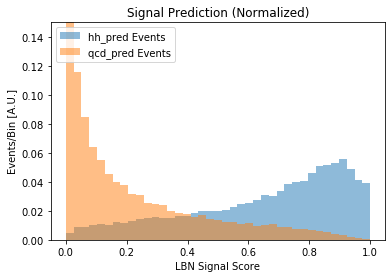

23724 34884
nSig = 1566.7535999999998 , nBkg = 1078153.04 with significance = 1.5089001279924428 +/- 0.03905905543706471 for ff-NN score > 0.8583895022218877
<class 'dict'> {}
++ Setting hyperparameters...
nLBNParticles = 5
nodesInFirstHiddenLayer = 80
nodesInSecondHiddenLayer = 256
hiddenActivation = relu
outputActivation = sigmoid
lossFunction = binary_crossentropy
++ Begin model training

Train on 136749 samples, validate on 58608 samples
Epoch 1/20
136749/136749 [==============================] - 9s 66us/sample - loss: 0.5880 - categorical_accuracy: 0.7018 - auc: 0.7804 - val_loss: 0.5608 - val_categorical_accuracy: 0.7185 - val_auc: 0.8062
Epoch 2/20
136749/136749 [==============================] - 6s 47us/sample - loss: 0.5266 - categorical_accuracy: 0.7499 - auc: 0.8324 - val_loss: 0.5131 - val_categorical_accuracy: 0.7567 - val_auc: 0.8411
Epoch 3/20
136749/136749 [==============================] - 6s 47us/sample - loss: 0.5036 - categorical_accuracy: 0.7655 - auc: 0.8478 - val

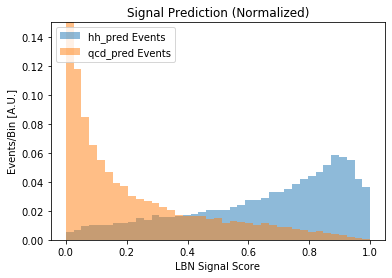

23724 34884
nSig = 1504.4591999999998 , nBkg = 863848.03 with significance = 1.6186827585810137 +/- 0.04588894888814256 for ff-NN score > 0.8684890622442419
<class 'dict'> {}
++ Setting hyperparameters...
nLBNParticles = 5
nodesInFirstHiddenLayer = 80
nodesInSecondHiddenLayer = 256
hiddenActivation = relu
outputActivation = sigmoid
lossFunction = binary_crossentropy
++ Begin model training

Train on 136749 samples, validate on 58608 samples
Epoch 1/20
136749/136749 [==============================] - 10s 69us/sample - loss: 0.5974 - categorical_accuracy: 0.6960 - auc: 0.7714 - val_loss: 0.5666 - val_categorical_accuracy: 0.7172 - val_auc: 0.8006
Epoch 2/20
136749/136749 [==============================] - 6s 46us/sample - loss: 0.5411 - categorical_accuracy: 0.7401 - auc: 0.8208 - val_loss: 0.5231 - val_categorical_accuracy: 0.7523 - val_auc: 0.8348
Epoch 3/20
136749/136749 [==============================] - 6s 46us/sample - loss: 0.5120 - categorical_accuracy: 0.7595 - auc: 0.8420 - val

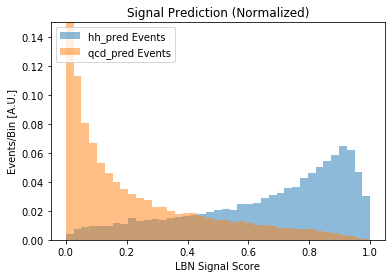

23724 34884
nSig = 1956.0935999999997 , nBkg = 1484669.76 with significance = 1.60536836537563 +/- 0.03583957928644458 for ff-NN score > 0.8380429425624886
<class 'dict'> {}
++ Setting hyperparameters...
nLBNParticles = 5
nodesInFirstHiddenLayer = 80
nodesInSecondHiddenLayer = 256
hiddenActivation = relu
outputActivation = sigmoid
lossFunction = binary_crossentropy
++ Begin model training

Train on 136749 samples, validate on 58608 samples
Epoch 1/20
136749/136749 [==============================] - 10s 72us/sample - loss: 0.6053 - categorical_accuracy: 0.6883 - auc: 0.7625 - val_loss: 0.5704 - val_categorical_accuracy: 0.7154 - val_auc: 0.7969
Epoch 2/20
136749/136749 [==============================] - 6s 45us/sample - loss: 0.5371 - categorical_accuracy: 0.7407 - auc: 0.8239 - val_loss: 0.5209 - val_categorical_accuracy: 0.7518 - val_auc: 0.8357
Epoch 3/20
136749/136749 [==============================] - 6s 46us/sample - loss: 0.5101 - categorical_accuracy: 0.7604 - auc: 0.8434 - val_

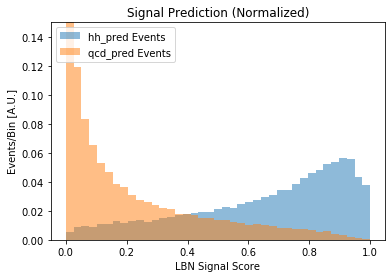

23724 34884
nSig = 1608.2831999999999 , nBkg = 1064897.06 with significance = 1.5585068353168847 +/- 0.04041243000674676 for ff-NN score > 0.8584852296896655
<class 'dict'> {}
++ Setting hyperparameters...
nLBNParticles = 5
nodesInFirstHiddenLayer = 80
nodesInSecondHiddenLayer = 256
hiddenActivation = relu
outputActivation = sigmoid
lossFunction = binary_crossentropy
++ Begin model training

Train on 136749 samples, validate on 58608 samples
Epoch 1/20
136749/136749 [==============================] - 9s 66us/sample - loss: 0.6000 - categorical_accuracy: 0.6983 - auc: 0.7699 - val_loss: 0.5633 - val_categorical_accuracy: 0.7190 - val_auc: 0.8019
Epoch 2/20
136749/136749 [==============================] - 6s 43us/sample - loss: 0.5355 - categorical_accuracy: 0.7436 - auc: 0.8253 - val_loss: 0.5240 - val_categorical_accuracy: 0.7483 - val_auc: 0.8326
Epoch 3/20
136749/136749 [==============================] - 6s 46us/sample - loss: 0.5109 - categorical_accuracy: 0.7585 - auc: 0.8422 - val

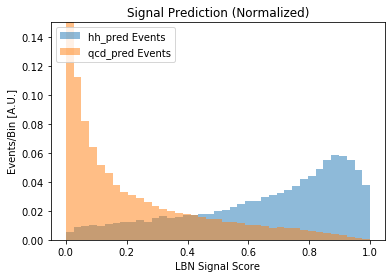

23724 34884
nSig = 1803.8183999999999 , nBkg = 1148851.5999999999 with significance = 1.6829098252686898 +/- 0.04183010583101301 for ff-NN score > 0.847937493613272


In [16]:
# *** X. Try multiple iterations with same hyperparameters and see collection results

iterations=5
results={}


for step in range(0, iterations):
    modelName = 'model_testMulti_60TrainEpochs_step{}'.format(step)

    model, history = fit_model(name=modelName, data=(trainVectorsByEvent, trainLabelsByEvent), 
                              validation_data=(testVectorsByEvent, testLabelsByEvent), epochs=60, batch_size=400)

    best_model = load_model( modelName )
    pred_hh = best_model.predict(np.array(hh_data_test))
    pred_qcd = best_model.predict(np.array(qcd_data_test))

    _nBins = 40
    predictionResults = {'hh_pred':pred_hh[:,0], 'qcd_pred':pred_qcd[:,0]}
    compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'LBN Signal Score', 0, 1, _nBins, _yMax = 5, _normed=True, _savePlot=False )

    # *** 4. Get best cut value for ff-NN assuming some minimal amount of signal
    sig, cut, sigErr = returnBestCutValue('ff-NN', pred_hh[:,0].copy(), pred_qcd[:,0].copy(), _minBackground=200, _testingFraction=testingFraction)
    
    results[step] = {'Sig': sig, 'Error': sigErr, 'Cut': cut}

In [17]:
print(results)

{0: {'Sig': 1.5089001279924428, 'Error': 0.03905905543706471, 'Cut': 0.8583895022218877}, 1: {'Sig': 1.6186827585810137, 'Error': 0.04588894888814256, 'Cut': 0.8684890622442419}, 2: {'Sig': 1.60536836537563, 'Error': 0.03583957928644458, 'Cut': 0.8380429425624886}, 3: {'Sig': 1.5585068353168847, 'Error': 0.04041243000674676, 'Cut': 0.8584852296896655}, 4: {'Sig': 1.6829098252686898, 'Error': 0.04183010583101301, 'Cut': 0.847937493613272}}


In [22]:
results

{0: {'Sig': 1.5089001279924428,
  'Error': 0.03905905543706471,
  'Cut': 0.8583895022218877},
 1: {'Sig': 1.6186827585810137,
  'Error': 0.04588894888814256,
  'Cut': 0.8684890622442419},
 2: {'Sig': 1.60536836537563,
  'Error': 0.03583957928644458,
  'Cut': 0.8380429425624886},
 3: {'Sig': 1.5585068353168847,
  'Error': 0.04041243000674676,
  'Cut': 0.8584852296896655},
 4: {'Sig': 1.6829098252686898,
  'Error': 0.04183010583101301,
  'Cut': 0.847937493613272}}

In [10]:
[x for x in range(1, 8+1)]

[1, 2, 3, 4, 5, 6, 7, 8]

In [16]:
type(np.empty([1, 32]))

numpy.ndarray

In [20]:
np.shape(testVectorsByEvent)

(58608, 32)